In [1]:
from brian2 import *
#from brian2tools import *
import numpy as np
%matplotlib inline

In [2]:
# SIMULATION PARAMETERS

prefs.codegen.target = 'numpy'
# the numerical resolution method that shall be used by Brian
diff_method = "euler"
time_step = 0.01 * ms
defaultclock.dt = time_step 

In [3]:
################################## NEURONS AND SYNAPSES PARAMETERS ################################## 

######### (A) Neuronal parameters, used in (1) and (4) ########

# time constants
tau_m = 1.0 * ms
tau_m_inh = 0.5 * ms
# membrane potential after reset
v_rest = 0.0
# spiking threshold
theta_u = 0.5
theta_inh = 0.01

########## (B) Synaptic parameters, used in (2) and (3) for different synapse types ######### 

# temporal layer to som layer (u to v)
tau_r_afferent = 0.2 * ms
tau_f_afferent = 1.0 * ms

# temporal layer (u to inh exc, u to inh inh, inh to u)
tau_r_exc = 0.4 * ms
tau_f_exc = 2.0 * ms
tau_r_inh = 0.2 * ms
tau_f_inh = 1.0 * ms
tau_r_inh2u = 1.0 * ms
tau_f_inh2u = 5.0 * ms

########## (C) Maximum magnitudes of synaptic connection strength ##########
w_syn_u2inh_exc_max = 1.0
w_syn_u2inh_inh_max = 1.0
w_syn_inh2u_max = 100.0

In [4]:
class ReceptiveField:
    # Parameter used in standard deviation definition
    gamma = 1.5

    def __init__(self, bank_size = 10, I_min = 0.05, I_max = 0.95):
        # number of units used to encode a real value  
        self.bank_size = bank_size
        # field_mu corresponds to the mean of the gaussian and shall be a numpy array 
        self.field_mu = ([0,0,0,0,0,0,0,0,0,0])
        for i in range (1,10):
            self.field_mu[i]=I_min+((((2*i)-2)/2)*((I_max-I_min)/(bank_size-1)))
        # field_sigma corresponds to the standard deviation of the gaussian and shall be a float
        self.field_sigma = (1/1.5)*(I_max-I_min)

    def float_to_potential(self, input_vector):
        try:
            input_vector = input_vector.reshape((input_vector.shape[0], 1))
            
        except Exception as exc:
            print("Exception: {0}\nObject shape: {1}".format(repr(exc), input_vector.shape))
            exit(1)
            
        result = exp(-((input_vector-self.field_mu)**2)/(2*(self.field_sigma**2)))
        return result   


In [20]:
rf = ReceptiveField()
inp_size = 2
inp_vector = np.array([0.2,0.4])

In [21]:
inp_potentials = rf.float_to_potential(inp_vector) 
inp_potentials

array([[0.94595947, 0.96923323, 0.9965338 , 0.9965338 , 0.96923323,
        0.91685536, 0.84354765, 0.7548396 , 0.65695557, 0.55610088],
       [0.8007374 , 0.84354765, 0.91685536, 0.96923323, 0.9965338 ,
        0.9965338 , 0.96923323, 0.91685536, 0.84354765, 0.7548396 ]])

In [22]:
u_layer_neuron_equ = '''
I_ext : 1
# inhibitory synapses to u layer : alpha functions
ds_inh2u/dt = (-s_inh2u)/tau_r_inh2u:1
dI_inh2u/dt = (s_inh2u-I_inh2u)/tau_f_inh2u :1

# membrane potential of u layer 
#dv/dt = (-v +I_ext - I_inh2u) / tau_m:1
#I_ext:1
dv/dt=(I_ext-v)/tau_m:1
'''


In [23]:
start_scope()
N = 10 * inp_size
u_layer = NeuronGroup(N,u_layer_neuron_equ, threshold='v>0.5', reset='v=0', method='exact')
u_layer.I_ext=inp_potentials.flatten()
u_layer.I_ext

<neurongroup.I_ext: array([0.94595947, 0.96923323, 0.9965338 , 0.9965338 , 0.96923323,
       0.91685536, 0.84354765, 0.7548396 , 0.65695557, 0.55610088,
       0.8007374 , 0.84354765, 0.91685536, 0.96923323, 0.9965338 ,
       0.9965338 , 0.96923323, 0.91685536, 0.84354765, 0.7548396 ])>

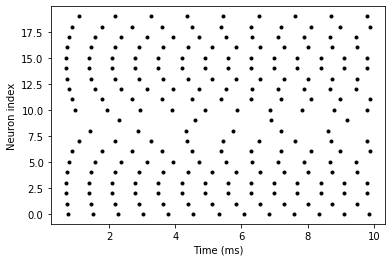

In [24]:
spikemon = SpikeMonitor(u_layer)

run(10*ms)
plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [10]:
inhibition_neuron_equ= '''
U_ext : 1

# inhibitory synapses to u layer : alpha functions
ds_u2inh/dt = (-s_u2inh) / tau_r_inh : 1
dI_u2inh/dt = (s_u2inh - I_u2inh) / tau_f_inh : 1

# membrane potential of u layer 
dv/dt = (-v +U_ext - I_u2inh) / tau_m : 1
'''

In [11]:
start_scope()
inhibition_neuron = NeuronGroup(N,inhibition_neuron_equ, threshold='v>0.5', reset='v=0', method='exact')
inhibition_neuron.U_ext=inp_potentials.flatten()

WARNING    <string>:13: RuntimeWarning: invalid value encountered in double_scalars
 [py.warnings]
WARNING    <string>:15: RuntimeWarning: invalid value encountered in double_scalars
 [py.warnings]
WARNING    <string>:19: RuntimeWarning: invalid value encountered in greater
 [py.warnings]
WARNING    neurongroup_1's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


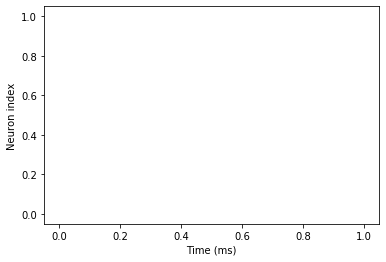

In [12]:
spikemon = SpikeMonitor(inhibition_neuron)

run(10*ms)
plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [13]:
model_synapse_inh2u_inhibition = '''
w_syn : 1
'''

on_pre_synapse_inh2u_inhibition = '''
s_inh2u += w_syn
'''

In [14]:
on_pre_synapse_u2inh_inhibition = '''
s_u2inh += w_syn
'''
on_pre_synapse_u2inh_exitation = '''
s_u2inh += w_syn
'''